# License Plate Detection Using Refactored Code

This notebook has been updated to use the refactored license plate detection code. The code has been reorganized into a structured Python package with separate modules for different functionalities:

- **data**: Data loading and preprocessing, augmentation
- **models**: Neural network architectures and custom loss functions
- **train**: Training utilities and learning rate scheduling
- **evaluation**: Model evaluation and error analysis
- **utils**: Visualization and analysis tools
- **main**: Main functionality for detecting license plates

Using this modular structure improves code organization, reusability, and maintainability.

# License Plate Detection with Refactored Code

This notebook demonstrates how to use the refactored license plate detection code organized as a Python package.

# Step1: Data load and data exploration
Here we will load the dataset and plot a image and it's corresponding bounding box of the plate in order to check that it matches the actual licence plate.

Current directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Notebooks
Project root: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection
Project root added to path: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection
TensorFlow version: 2.18.0
Data path: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset
Images directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset\images
Annotations directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset\annotations
Loaded 1122 annotations, skipped 0 files


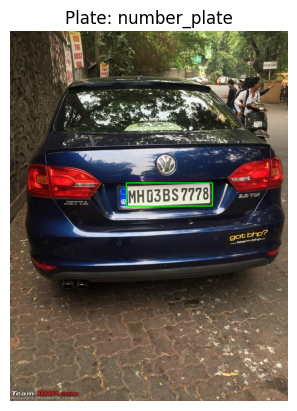

,image_path,x,y,w,h,plate_text
0,c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\...,935,362,99,49,licence
1,c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\...,911,136,62,31,licence
2,c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\...,569,318,63,31,licence
3,c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\...,698,85,58,29,licence
4,c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\...,428,207,58,29,licence


In [7]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import sys
import random

# Check if running in Colab
import importlib.util
IN_COLAB = importlib.util.find_spec("google.colab") is not None

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

if IN_COLAB:
    # Add project root to path to ensure imports work correctly
    project_root = os.path.join(current_dir, "Car-plate-detection")
    sys.path.insert(0, project_root)
    print(f"Project root added to path: {project_root}")
    DATA_PATH = Path(project_root+"/Dataset")
else:
    # If not in Colab, set the project root to the current working directory's parent
    project_root = Path(os.getcwd()).parent
    print(f"Project root: {project_root}")
    # Add project root to path to fix import errors
    sys.path.insert(0, str(project_root))
    print(f"Project root added to path: {project_root}")
    DATA_PATH = project_root / "Dataset"

# Fix import redundancy by controlling import order and preventing code repetition
print(f"TensorFlow version: {tf.__version__}")

# First import low-level modules that don't depend on others
from license_plate_detection.models.losses import enhanced_iou_metric, combined_detection_loss, giou_loss
from license_plate_detection.models.detector import create_license_plate_detector, create_enhanced_license_plate_detector

# Then import data handling modules
from license_plate_detection.data.loader import get_data_path, load_license_plate_dataset, preprocess_license_plate_dataset, split_dataset
from license_plate_detection.data.augmentation import augment_data, visualize_augmentation

# Then import higher-level modules
from license_plate_detection.train.trainer import train_model, save_model
from license_plate_detection.train.scheduler import create_lr_scheduler
from license_plate_detection.evaluation.evaluator import evaluate_license_plate_detection, evaluate_model_comprehensive
from license_plate_detection.evaluation.error_analysis import analyze_predictions
from license_plate_detection.utils.visualization import visualize_prediction, plot_training_history as visualize_training_history
from license_plate_detection.utils.analysis import analyze_error_patterns

# Finally import the helpers module
from license_plate_detection.utils.helpers import detect_license_plate, load_and_prepare_model

# Get paths to dataset using our refactored function
data_path = get_data_path()
IMAGES_PATH = data_path / "images"
ANNOTATIONS_PATH = data_path / "annotations"

# Check if the dataset paths exist
if not data_path.exists():
    raise FileNotFoundError(f"Data path does not exist: {data_path}\n"
                            "Please check the path or create the folder and add your data.")
if not IMAGES_PATH.exists():
    raise FileNotFoundError(f"Images directory does not exist: {IMAGES_PATH}")
if not ANNOTATIONS_PATH.exists():
    raise FileNotFoundError(f"Annotations directory does not exist: {ANNOTATIONS_PATH}")

print(f"Data path: {data_path}")
print(f"Images directory: {IMAGES_PATH}")
print(f"Annotations directory: {ANNOTATIONS_PATH}")

# Load the dataset using the specialized function that returns a DataFrame
df = load_license_plate_dataset(ANNOTATIONS_PATH, IMAGES_PATH)

# Visualize a sample - only if we have at least one image
if len(df) > 0:
    # Take first sample or specific index if available
    sample_idx = min(1000, len(df) - 1)  # Ensure index exists
    sample = df.iloc[sample_idx]
    img = cv2.imread(sample["image_path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding box
    x, y, w, h = sample["x"], sample["y"], sample["w"], sample["h"]
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(img_rgb)
    if "plate_text" in sample and sample["plate_text"] != "Unknown":
        plt.title(f"Plate: {sample['plate_text']}")
    plt.axis('off')
    plt.show()
else:
    print("No images loaded. Please check dataset path and XML format.")

# Show the first few rows of the loaded dataset for inspection
df.head()

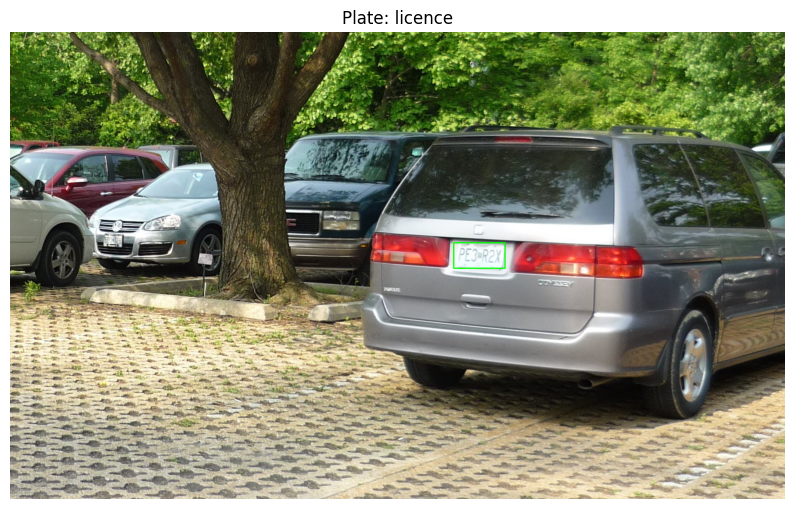

In [9]:
# Visualize a sample image from the dataset
if len(df) > 0:
    # Take a specific sample or a random one
    sample_idx = min(42, len(df) - 1)  # Ensure index exists
    sample = df.iloc[sample_idx]
    
    # Load the image
    img = cv2.imread(sample["image_path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw bounding box
    x, y, w, h = sample["x"], sample["y"], sample["w"], sample["h"]
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    if "plate_text" in sample and sample["plate_text"] != "Unknown":
        plt.title(f"Plate: {sample['plate_text']}")
    plt.axis('off')
    plt.show()
else:
    print("No images loaded. Please check dataset path.")

# Step 2: Data Preprocessing

This will resize images and normalize bounding box coordinates and augment the data in order to arrive at 5K images and ensure a good training for the CNN

In [ ]:
# Preprocess the dataset using the specialized function
IMAGE_SIZE = (224, 224)  # Target size for CNN
X, y = preprocess_license_plate_dataset(df, image_size=IMAGE_SIZE)

print(f"Processed {len(X)} images.")
print("Image shape:", X[0].shape)
print("Sample bounding box (normalized):", y[0])

# Visualize a processed sample
def visualize_processed_sample(index=0):
    if index >= len(X) or index < 0:
        print(f"Index {index} is out of bounds.")
        return
        
    img_normalized = X[index]
    bbox_norm = y[index]
    original_row = df.iloc[index]
    
    # Load the original image
    img_original = cv2.imread(original_row["image_path"])
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    
    # Draw original bbox
    x_orig, y_orig, w_orig, h_orig = original_row["x"], original_row["y"], original_row["w"], original_row["h"]
    img_original_vis = img_original.copy()
    cv2.rectangle(img_original_vis, (x_orig, y_orig), (x_orig + w_orig, y_orig + h_orig), (255, 0, 0), 2)
    
    # Prepare normalized image
    img_vis = (img_normalized * 255).astype(np.uint8).copy()
    x_norm = int(bbox_norm[0] * IMAGE_SIZE[0])
    y_norm = int(bbox_norm[1] * IMAGE_SIZE[1])
    w_norm = int(bbox_norm[2] * IMAGE_SIZE[0])
    h_norm = int(bbox_norm[3] * IMAGE_SIZE[1])
    cv2.rectangle(img_vis, (x_norm, y_norm), (x_norm + w_norm, y_norm + h_norm), (0, 255, 0), 2)
    
    # Plot side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(img_original_vis)
    axs[0].set_title('Original Image with Original BBox')
    axs[0].axis('off')
    
    axs[1].imshow(img_vis)
    axs[1].set_title('Normalized & Resized Image with BBox')
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show a processed sample
visualize_processed_sample(0)

### Data Augmentation

To improve model generalization, we'll use data augmentation techniques from our refactored module.

In [ ]:
# Apply data augmentation
X_aug, y_aug = augment_data(X, y, augmentation_factor=4)

# Visualize some augmented samples
visualize_augmentation(X, y, X_aug, y_aug, num_samples=4)

# 2. Split data into training and validation sets
X_train, X_val, y_train, y_val = split_dataset(X_aug, y_aug, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Step 3: Model Architecture definition

Now we'll create the license plate detection model. We will try 5 different architectures:
1. Basic License Plate Detector
2. Enhanced License Plate Detector
3. MobileNetV2-Based License Plate Detector
4. EfficientNet-Based License Plate Detector
5. Optimized License Plate Detector (CNN_Liscence_Plate_Detection.ipynb)

In [ ]:
# Create the enhanced model from the refactored module
model = create_enhanced_license_plate_detector(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Display model summary
model.summary()

# Print model size information
trainable_count = np.sum([keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f'Total parameters: {trainable_count + non_trainable_count:,}')
print(f'Trainable parameters: {trainable_count:,}')
print(f'Non-trainable parameters: {non_trainable_count:,}')

# Step 4: Model Training

Now we'll compile and train the model using our custom loss functions and  learning rate scheduling.

We have different posibilitis for the training:
1. Create callbacks for model training
2. Train a license plate detection model
3. Train a license plate detection model with on-the-fly data augmentation
4. Save a trained model

We have different possibilitis for the loss function:
1. Mean IoU loss
2. Combined detection loss (iou loss * 0.5 + position loss * 0.3 + size loss * 0.2)
3. GIoU loss
4. Focal loss

We have as well different learning rate scheduelers:
1. Cosine decay learning rate scheduler
2. Step decay learning rate scheduler
3. step_decay_scheduler : Creates a step decay learning rate scheduler

In [ ]:
# Compile model with custom loss functions from refactored module
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=combined_detection_loss,
    metrics=[enhanced_iou_metric, giou_loss]
)

# Create callbacks using refactored modules
callbacks = [
    # Learning rate scheduler from our module
    create_lr_scheduler(
        scheduler_type='cosine',
        initial_learning_rate=0.001,
        epochs=50,
        warmup_epochs=5
    ),
    
    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_enhanced_iou_metric',
        patience=20,
        restore_best_weights=True,
        mode='max'
    ),
    
    # Model checkpoint
    keras.callbacks.ModelCheckpoint(
        'enhanced_license_plate_detector.h5',
        monitor='val_enhanced_iou_metric',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]



# Train model (commented out to avoid accidental training)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

# Visualize training history using refactored function
visualize_training_history(history)

# Save model using refactored function
save_model(model, 'license_plate_detector_final.h5')


# Alternatively, use the train_model function from our refactored module
"""
history, model = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    loss_function=combined_detection_loss,
    metrics=[enhanced_iou_metric],
    epochs=50,
    batch_size=16,
    callbacks=callbacks
)
"""

# Step 6: Model Evaluation

Let's evaluate our model using the evaluation functions from our refactored module.

In [ ]:
# For demonstration purposes, generate demo predictions
def generate_demo_predictions(model, X_val, y_val):
    """Generate plausible demo predictions for visualization purposes"""
    # Get predictions from untrained model
    random_preds = model.predict(X_val)
    
    # Make them somewhat reasonable by combining with ground truth
    demo_preds = []
    for i, (pred, gt) in enumerate(zip(random_preds, y_val)):
        # Create a prediction that's a noisy version of ground truth
        noise = np.random.normal(0, 0.1, 4)  # Add some noise
        noisy_pred = gt + noise
        
        # Ensure values are in range [0, 1]
        noisy_pred = np.clip(noisy_pred, 0, 1)
        
        # Make width and height reasonable
        noisy_pred[2] = max(0.05, min(noisy_pred[2], 0.5))  # Width
        noisy_pred[3] = max(0.05, min(noisy_pred[3], 0.3))  # Height
        
        demo_preds.append(noisy_pred)
    
    return np.array(demo_preds)

# Generate demo predictions
demo_predictions = generate_demo_predictions(model, X_val, y_val)

# Run evaluation with demo predictions using the refactored evaluator
# In a real scenario, you would use true model predictions
#results = evaluate_license_plate_detection(model, X_val, y_val, demo_predictions)

# You could also run a comprehensive evaluation
comprehensive_results = evaluate_model_comprehensive(model, X_val, y_val, demo_predictions)

# Step 7: Error Analysis

Performs a detailed analysis of prediction errors to help you understand where and why your license plate detection model makes mistakes. This provides valuable insights for model improvement.

In [ ]:
# Analyze error patterns using the refactored module
error_analysis = analyze_error_patterns(
    X_val=X_val,
    y_val=y_val,
    y_pred=demo_predictions,
    plate_sizes=[box[2] * box[3] for box in y_val]
)

## License Plate Detection

Finally, let's use our model to detect license plates in new images using the refactored module.

In [ ]:
# For demonstration purposes, use a sample image from our dataset
if len(df) > 0:
    sample_img_path = df.iloc[10]["image_path"]

    # In a real scenario, you would use the refactored function with a trained model
    # plate_region, bbox = detect_license_plate(sample_img_path, model, confidence_threshold=0.5)
    
    # For demo purposes, simulate detection
    def demo_detect_license_plate(image_path):
        """Simulate license plate detection for demonstration"""
        # Load image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img_rgb.shape[:2]
        
        # Get ground truth from dataset if available
        file_name = os.path.basename(image_path)
        matched_rows = df[df["image_path"].str.contains(file_name)]
        
        if len(matched_rows) > 0:
            # Use ground truth with small random offset
            row = matched_rows.iloc[0]
            x, y, w, h = row["x"], row["y"], row["w"], row["h"]
            
            # Add some noise to simulate prediction
            noise_factor = 0.1
            x += int(np.random.normal(0, w * noise_factor))
            y += int(np.random.normal(0, h * noise_factor))
            w += int(np.random.normal(0, w * noise_factor))
            h += int(np.random.normal(0, h * noise_factor))
            
            # Ensure values are valid
            x = max(0, min(x, orig_w - 10))
            y = max(0, min(y, orig_h - 10))
            w = max(10, min(w, orig_w - x))
            h = max(10, min(h, orig_h - y))
        else:
            # Generate random detection
            x = int(orig_w * 0.4)
            y = int(orig_h * 0.4)
            w = int(orig_w * 0.2)
            h = int(orig_h * 0.1)
        
        # Draw detection on image
        result_img = img_rgb.copy()
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Display result
        plt.figure(figsize=(10, 8))
        plt.imshow(result_img)
        plt.axis('off')
        plt.title("License Plate Detection (Demo)")
        plt.show()
        
        # Extract plate region
        plate_region = img_rgb[y:y + h, x:x + w]
        
        # Show extracted plate
        plt.figure(figsize=(6, 2))
        plt.imshow(plate_region)
        plt.axis('off')
        plt.title("Extracted License Plate")
        plt.show()
        
        return plate_region, [x, y, w, h]

    # Detect license plate in sample image
    demo_detect_license_plate(sample_img_path)
else:
    print("No images available for demonstration.")